# Red neuronal LSTM para predecir niveles del río Orinoco


In [43]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import numpy as np
from keras import Sequential, layers
import tensorflow as tf

In [44]:
# data = pd.read_csv("data/dataset_combinado.csv")
data = pd.read_csv("data/dataset_imputado_simpleml.csv")
data.head()

,fecha,ayacucho,caicara,ciudad_bolivar,palua
0,1974/01/01,43.34,24.98,6.89,3.83
1,1974/01/02,43.25,24.88,6.78,3.93
2,1974/01/03,43.14,24.78,6.73,3.75
3,1974/01/04,43.04,24.68,6.68,3.49
4,1974/01/05,42.94,24.58,6.62,3.64


In [45]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18683 entries, 0 to 18682
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   fecha           18683 non-null  object 
 1   ayacucho        18683 non-null  float64
 2   caicara         18683 non-null  float64
 3   ciudad_bolivar  18683 non-null  float64
 4   palua           18666 non-null  float64
dtypes: float64(4), object(1)
memory usage: 729.9+ KB


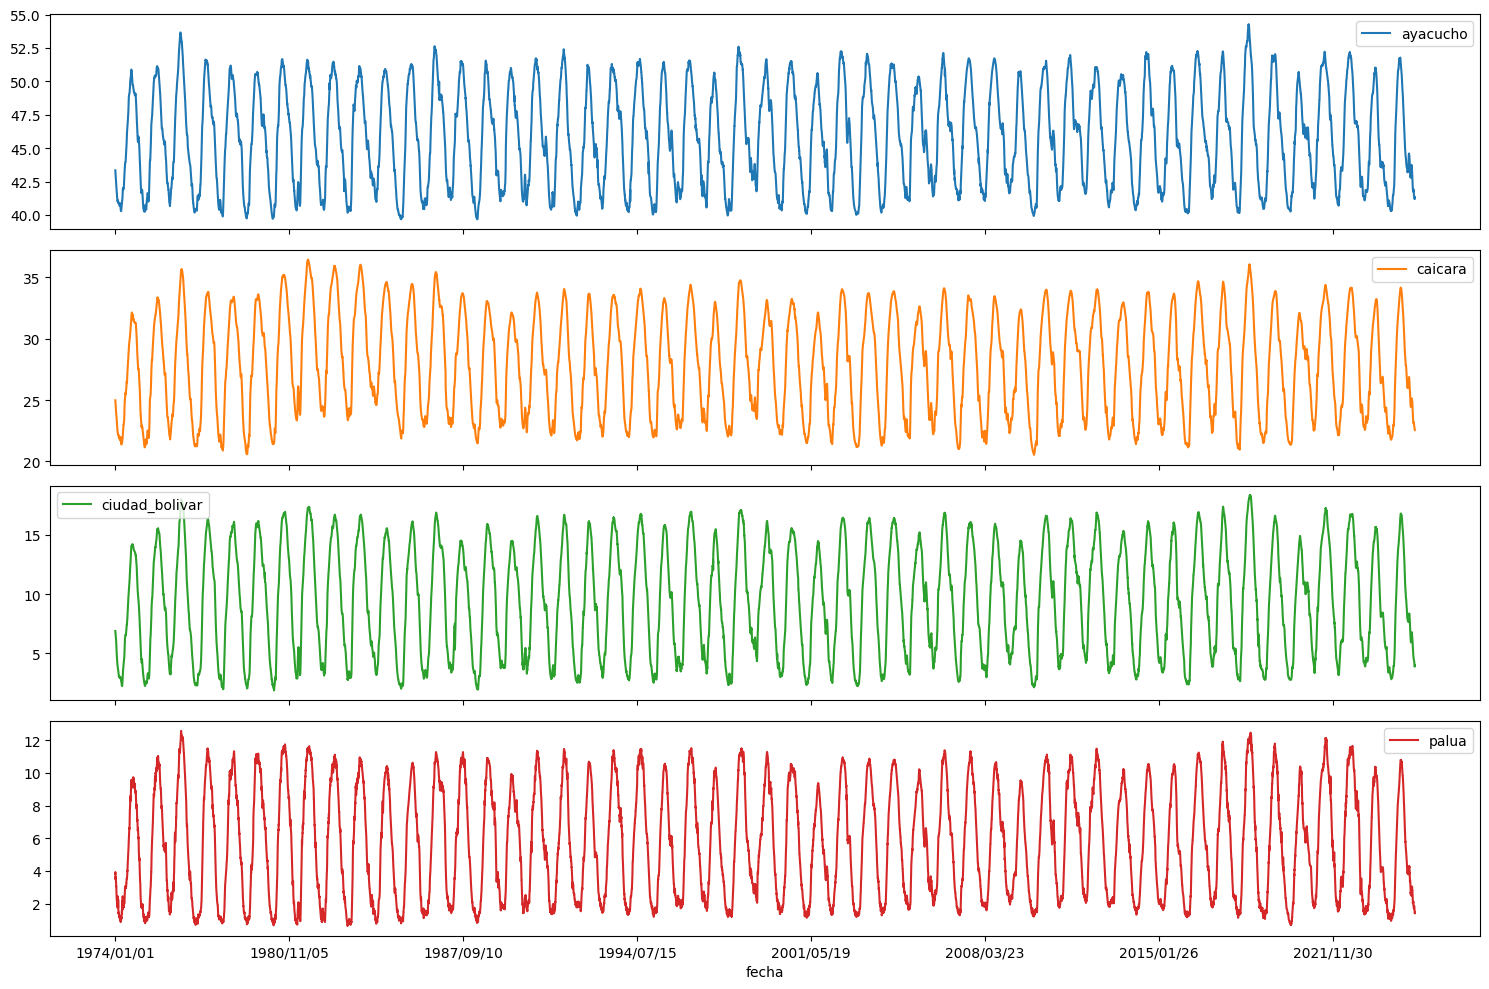

In [46]:
# Graficar valores de cada columna
data.set_index("fecha")[["ayacucho", "caicara", "ciudad_bolivar", "palua"]].plot(
    subplots=True, figsize=(15, 10)
)
plt.tight_layout()

In [47]:
# Interpolación de valores faltantes
data["palua"] = data["palua"].interpolate(method="linear", limit_direction="both")
# data["fecha"] = pd.to_datetime(data["fecha"])
# mask = data['fecha'].dt.year.isin([2007, 2008])
# data.loc[mask, "palua"] = data.loc[mask, "palua"].interpolate(
#     method="linear", limit_direction="both"
# )

In [48]:
# Graficar valores de cada columna
# data[["ayacucho", "caicara", "ciudad_bolivar", "palua"]].plot(
#     subplots=True, figsize=(15, 10)
# )
# plt.tight_layout()

In [49]:
# Eliminar registros con valores nulos
data.dropna(inplace=True)

In [50]:
# Normalizar las nuevas características
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data[[
    'ayacucho',
    'caicara',
    'ciudad_bolivar',
    'palua',
]])

In [48]:
# Guardar el scaler
import joblib
joblib.dump(scaler, "modelos/scaler.gz")

['modelos/scaler.gz']

In [51]:
# Crear secuencias para predecir múltiples días futuros
sequence_length = 365  # Ventana de entrada
forecast_steps = 14   # Número de días futuros a predecir
batch_size = 128

In [36]:
# Elegir índice de corte para training y testing (por ejemplo 80% para training)
split_index = int(len(data_scaled) * 0.8)

# Asegurarse de que haya suficientes datos para generar secuencias
if split_index < sequence_length + forecast_steps:
    raise ValueError("El conjunto de datos es demasiado pequeño para generar las secuencias requeridas.")

train_data = data_scaled[:split_index]
test_data = data_scaled[split_index:]

In [37]:
def split_sequences(sequences, n_steps_in: int, n_steps_out: int):
    """
    Divide una secuencia multivariada en muestras de entrada y salida

    Usado para problemas donde se reciben múltiples secuencias, y
    se desea predecir el siguiente valor de cada una

    Tomado de
    https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/
    """
    X, y = list(), list()
    for i in range(len(sequences)):
		# find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [38]:
train_X, train_y = split_sequences(train_data, sequence_length, forecast_steps)
test_X, test_y = split_sequences(test_data, sequence_length, forecast_steps)

# Visualizar
print(train_X[0], train_y[0])

[[-0.67999201 -0.71232562 -0.5648475  -0.56260059]
 [-0.70416377 -0.73634341 -0.58878236 -0.53317924]
 [-0.73370702 -0.7603612  -0.59966185 -0.58613767]
 ...
 [-0.86262305 -0.92848572 -0.80419612 -0.91565683]
 [-0.91096656 -0.95250351 -0.84336226 -0.98332594]
 [-0.95125282 -1.00053909 -0.8781766  -1.00392089]] [[-0.97005308 -1.00053909 -0.91081505 -1.00980516]
 [-1.01033934 -1.02455688 -0.9391017  -1.04216865]
 [-1.03719684 -1.04857467 -0.96956425 -1.0627636 ]
 [-1.0506256  -1.07259246 -0.99785091 -1.08630068]
 [-1.09091186 -1.09661024 -1.01525808 -1.10395349]
 [-1.10702636 -1.14464582 -1.04354473 -1.11572203]
 [-1.12045511 -1.16866361 -1.0674796  -1.14514338]
 [-1.13119812 -1.18067251 -1.08053498 -1.15985406]
 [-1.13656962 -1.1926814  -1.08053498 -1.15102766]
 [-1.13388387 -1.2046903  -1.07835908 -1.13925911]
 [-1.11239786 -1.21669919 -1.08053498 -1.13337484]
 [-1.10165486 -1.22870809 -1.09359035 -1.12749057]
 [-1.07479735 -1.24071698 -1.10882163 -1.13631698]
 [-1.06405435 -1.24071698

In [ ]:
n_features = train_X.shape[2] # Número de características

# Ajustar el modelo para predecir forecast_steps valores futuros
# model = Sequential(
#     [
#         layers.LSTM(
#             units=100,
#             activation="relu",
#             input_shape=(sequence_length, n_features),
#         ),
#         layers.Dropout(0.3),
#         layers.RepeatVector(forecast_steps),
#         layers.LSTM(units=100, activation="relu", return_sequences=True),
#         layers.Dropout(0.3),
#         layers.TimeDistributed(layers.Dense(n_features)),
#     ]
# )
model = Sequential(
    [
        layers.Input(shape=(sequence_length, n_features)),
        # layers.Conv1D(
        #     filters=32, kernel_size=3, activation="relu"
        # ),  # Capturar patrones locales
        layers.LSTM(100),
        # layers.Dropout(0.4),
        # layers.LSTM(100),
        # layers.Dropout(0.4),
        layers.Dense(
            forecast_steps * 4
        ),  # Ajustar el número de unidades para que coincida con forecast_steps * 4
        layers.Reshape(
            (forecast_steps, 4)
        ),  # Cambiar la forma de la salida a (forecast_steps, 4)
    ]
)

# Compilar el modelo
model.compile(
    optimizer='adam',
    loss="mean_squared_error",
    metrics=["mean_absolute_error"],
)

In [40]:
# Entrenar el modelo con más épocas
history = model.fit(
    train_X,
    train_y,
    validation_data=(test_X, test_y),
    epochs=5,
    batch_size=batch_size,
    verbose=1,
)

Epoch 1/5
114/114 ━━━━━━━━━━━━━━━━━━━━ 28s 236ms/step - loss: 0.3647 - mean_absolute_error: 0.4427 - val_loss: 0.0207 - val_mean_absolute_error: 0.1106
Epoch 2/5
114/114 ━━━━━━━━━━━━━━━━━━━━ 26s 230ms/step - loss: 0.0221 - mean_absolute_error: 0.1091 - val_loss: 0.0155 - val_mean_absolute_error: 0.0941
Epoch 3/5
114/114 ━━━━━━━━━━━━━━━━━━━━ 26s 229ms/step - loss: 0.0170 - mean_absolute_error: 0.0952 - val_loss: 0.0135 - val_mean_absolute_error: 0.0869
Epoch 4/5
114/114 ━━━━━━━━━━━━━━━━━━━━ 26s 229ms/step - loss: 0.0129 - mean_absolute_error: 0.0822 - val_loss: 0.0119 - val_mean_absolute_error: 0.0805
Epoch 5/5
114/114 ━━━━━━━━━━━━━━━━━━━━ 26s 227ms/step - loss: 0.0115 - mean_absolute_error: 0.0771 - val_loss: 0.0110 - val_mean_absolute_error: 0.0768


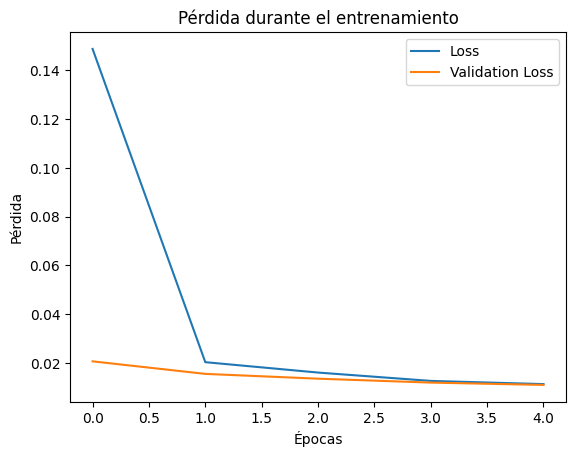

In [41]:
# Graficar la pérdida durante el entrenamiento
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Pérdida durante el entrenamiento")
plt.xlabel("Épocas")
plt.ylabel("Pérdida")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
Predicciones (10 días x 4 ciudades):
[[40.9887    22.469398   3.536296   1.6703101]
 [40.915867  22.49363    3.4023824  1.6727477]
 [40.95146   22.48563    3.4193163  1.6043807]
 [40.98283   22.459988   3.4281821  1.7161304]
 [41.134544  22.456654   3.7397437  1.4586464]
 [41.063133  22.448051   3.5092187  1.5744454]
 [40.94754   22.493923   3.543706   1.4631082]
 [41.101208  22.500425   3.6096783  1.6121761]
 [41.198414  22.589035   3.4771152  1.554967 ]
 [41.11847   22.588322   3.3919215  1.5540558]
 [41.0527    22.652897   3.4072556  1.6927801]
 [41.12255   22.40676    3.5594225  1.6199952]
 [41.1851    22.605927   3.410532   1.4879357]
 [41.16755   22.598856   3.6346755  1.6938573]]
Valores reales (si están disponibles):
[[40.9  22.5   3.68  1.39]
 [40.84 22.5   3.63  1.35]
 [40.75 22.47  3.58  1.32]
 [40.7  22.36  3.54  1.31]
 [40.7  22.36  3.53  1.25]
 [40.67 22.29  3.5   1.23]
 [40.57 22.23  3.46  1.17]
 [40.51 22.17  3.39  1.13]
 [40.47 22

<Figure size 1000x600 with 0 Axes>

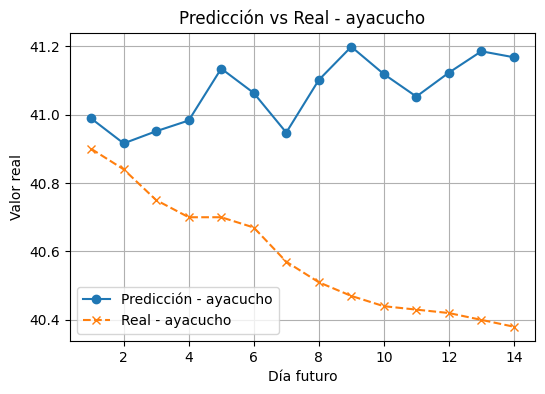

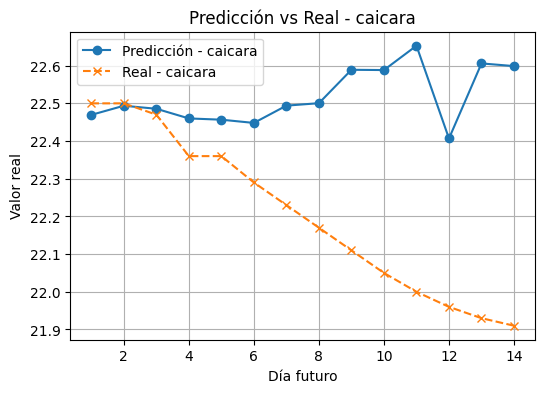

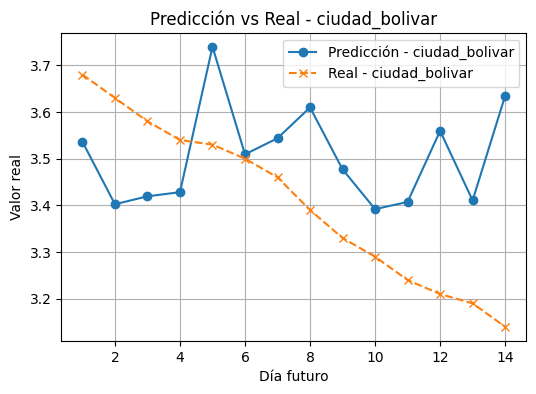

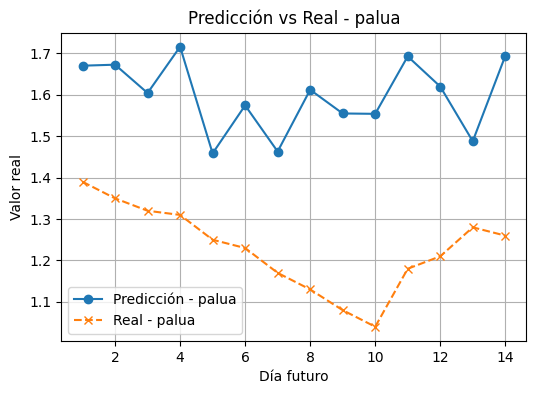

In [42]:
# Tomar la última secuencia del set de test para predecir los próximos 10 días
last_sequence = test_data[-sequence_length:]
last_sequence = last_sequence.reshape((1, sequence_length, test_data.shape[1]))

# Predecir los próximos 10 días para las 4 ciudades
future_pred = model.predict(last_sequence)  # shape: (1, 10, 4)
future_pred = future_pred[0]  # shape: (10, 4)

# Desnormalizar la salida para obtener los valores reales
future_pred_real = scaler.inverse_transform(future_pred)

# Obtener los valores reales correspondientes (si están disponibles)
try:
    real_future = scaler.inverse_transform(test_data[-sequence_length: -sequence_length + forecast_steps, :4])
except Exception:
    real_future = None

print("Predicciones (10 días x 4 ciudades):")
print(future_pred_real)
print("Valores reales (si están disponibles):")
print(real_future)

# Graficar
ciudades = ['ayacucho', 'caicara', 'ciudad_bolivar', 'palua']
dias = np.arange(1, forecast_steps + 1)

plt.figure(figsize=(10, 6))
for i, ciudad in enumerate(ciudades):
    plt.figure(figsize=(6, 4))
    plt.plot(dias, future_pred_real[:, i], marker='o', label=f'Predicción - {ciudad}')
    if real_future is not None and real_future.shape == (forecast_steps, 4):
        plt.plot(dias, real_future[:, i], marker='x', linestyle='--', label=f'Real - {ciudad}')
    plt.xlabel('Día futuro')
    plt.ylabel('Valor real')
    plt.title(f'Predicción vs Real - {ciudad}')
    plt.legend()
    plt.grid()
    plt.show()

In [45]:
# Guardar el modelo como .keras
model.save("modelos/modelo_lstm_simple.keras")

In [52]:
modelo_importado = tf.keras.models.load_model("modelos/modelo_lstm_simple.keras")

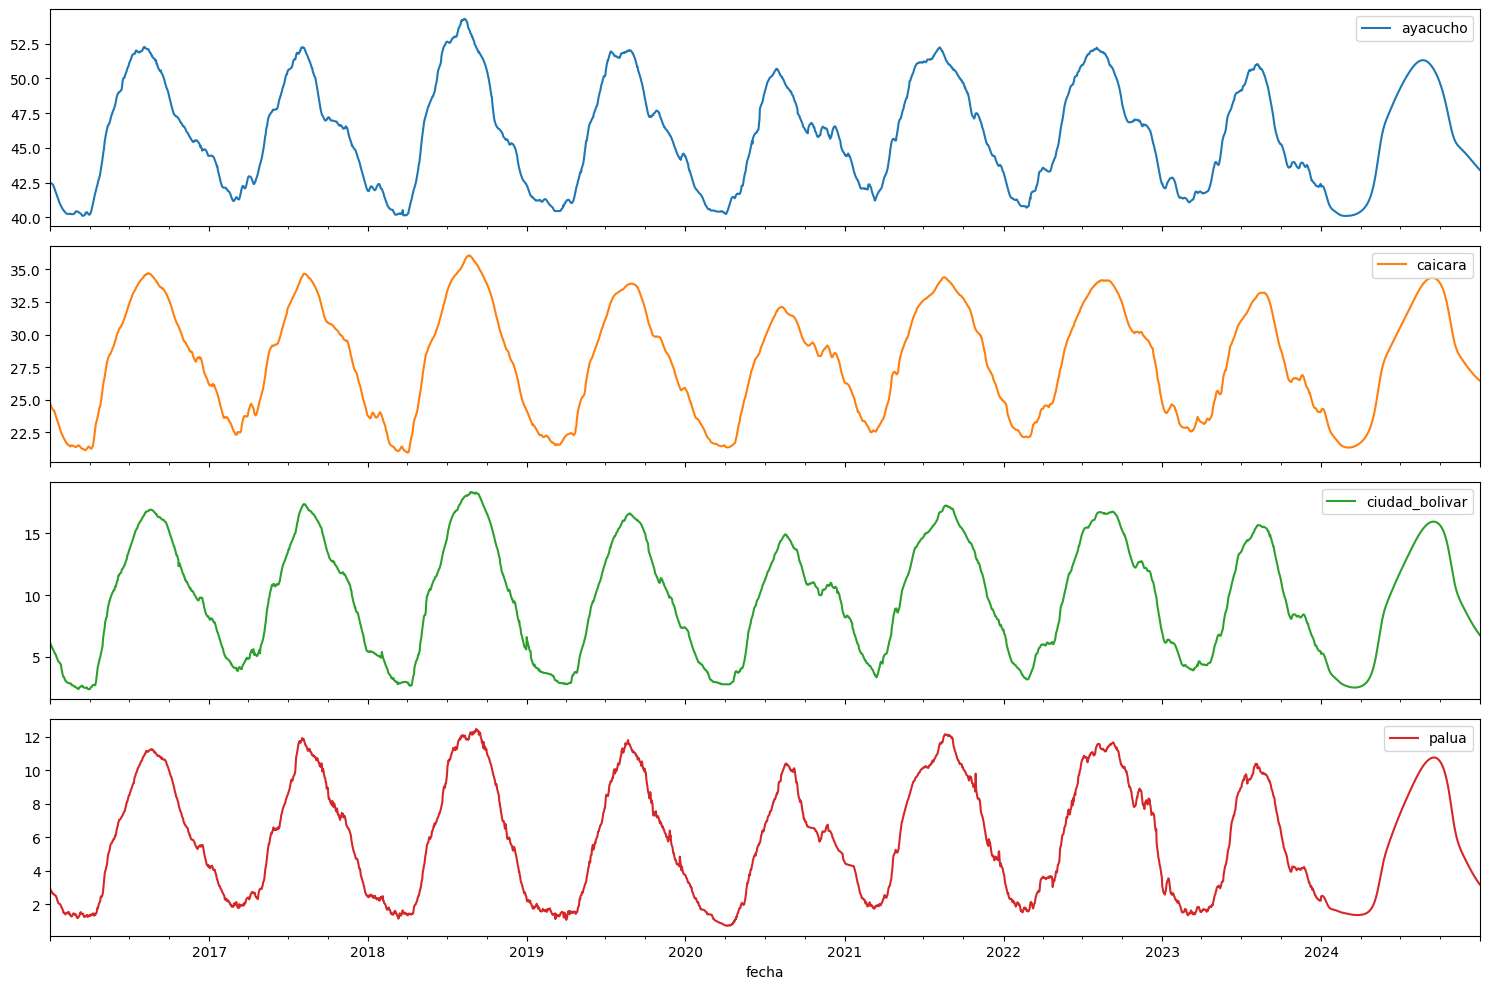

In [53]:
# Utiliza el modelo para hacer predicciones desde el 01/01/2024 hasta el 31/12/2024
# Visualiza el dataset original completo, y el dataset reemplazando los valores de 2024 con las predicciones
# Ignora los valores de 2025 en ambos casos

# Crear un rango de fechas para el año 2024
date_range_2024 = pd.date_range(start="2024-01-01", end="2024-12-31", freq="D")
n_days_2024 = len(date_range_2024)

# Inicializar lista para guardar predicciones
predicciones_2024 = []

# Obtener la última secuencia real antes de 2024
data["fecha"] = pd.to_datetime(data["fecha"])
idx_2024 = data[data["fecha"] == pd.to_datetime("2024-01-01")].index[0]
# Usar datos reales hasta el 31/12/2023
secuencia_actual = data_scaled[idx_2024 - sequence_length : idx_2024].copy()

for i in range(n_days_2024):
    # Predecir los próximos forecast_steps días
    entrada = secuencia_actual[-sequence_length:].reshape(
        1, sequence_length, data_scaled.shape[1]
    )
    prediccion = modelo_importado.predict(entrada, verbose=0)[0]  # (forecast_steps, 4)
    # Tomar solo el primer día predicho
    predicciones_2024.append(prediccion[0])
    # Construir la siguiente secuencia: agregar la predicción y quitar el primer día
    nuevo_vector = np.zeros(data_scaled.shape[1])
    nuevo_vector[:4] = prediccion[0]
    # Si tienes columnas adicionales (por ejemplo, mes, día del año), actualízalas:
    if data_scaled.shape[1] > 4:
        fecha_pred = date_range_2024[i]
        # Normaliza mes y día_del_anio igual que en el escalador original
        mes = (fecha_pred.month - scaler.mean_[4]) / scaler.scale_[4]
        dia_del_anio = (fecha_pred.dayofyear - scaler.mean_[5]) / scaler.scale_[5]
        nuevo_vector[4] = mes
        nuevo_vector[5] = dia_del_anio
    secuencia_actual = np.vstack([secuencia_actual, nuevo_vector])

# Convertir predicciones a DataFrame y desnormalizar
predicciones_2024 = np.array(predicciones_2024)
predicciones_2024_real = scaler.inverse_transform(
    np.hstack([predicciones_2024, np.zeros((n_days_2024, data_scaled.shape[1] - 4))])
)[:, :4]
predictions_df = pd.DataFrame(
    predicciones_2024_real, columns=ciudades, index=date_range_2024
)

# Reemplazar los valores de 2024 en el DataFrame original con las predicciones
data_2024 = data[data["fecha"].dt.year == 2024].copy()
data_2024[ciudades] = predictions_df.values
# Concatenar el DataFrame original con las predicciones de 2024
data_combined = pd.concat([data[data["fecha"].dt.year < 2024], data_2024])
# Graficar el dataset combinado
data_combined[data_combined["fecha"] > "2016/01/01"].set_index("fecha")[ciudades].plot(subplots=True, figsize=(15, 10))
plt.tight_layout()
plt.show()

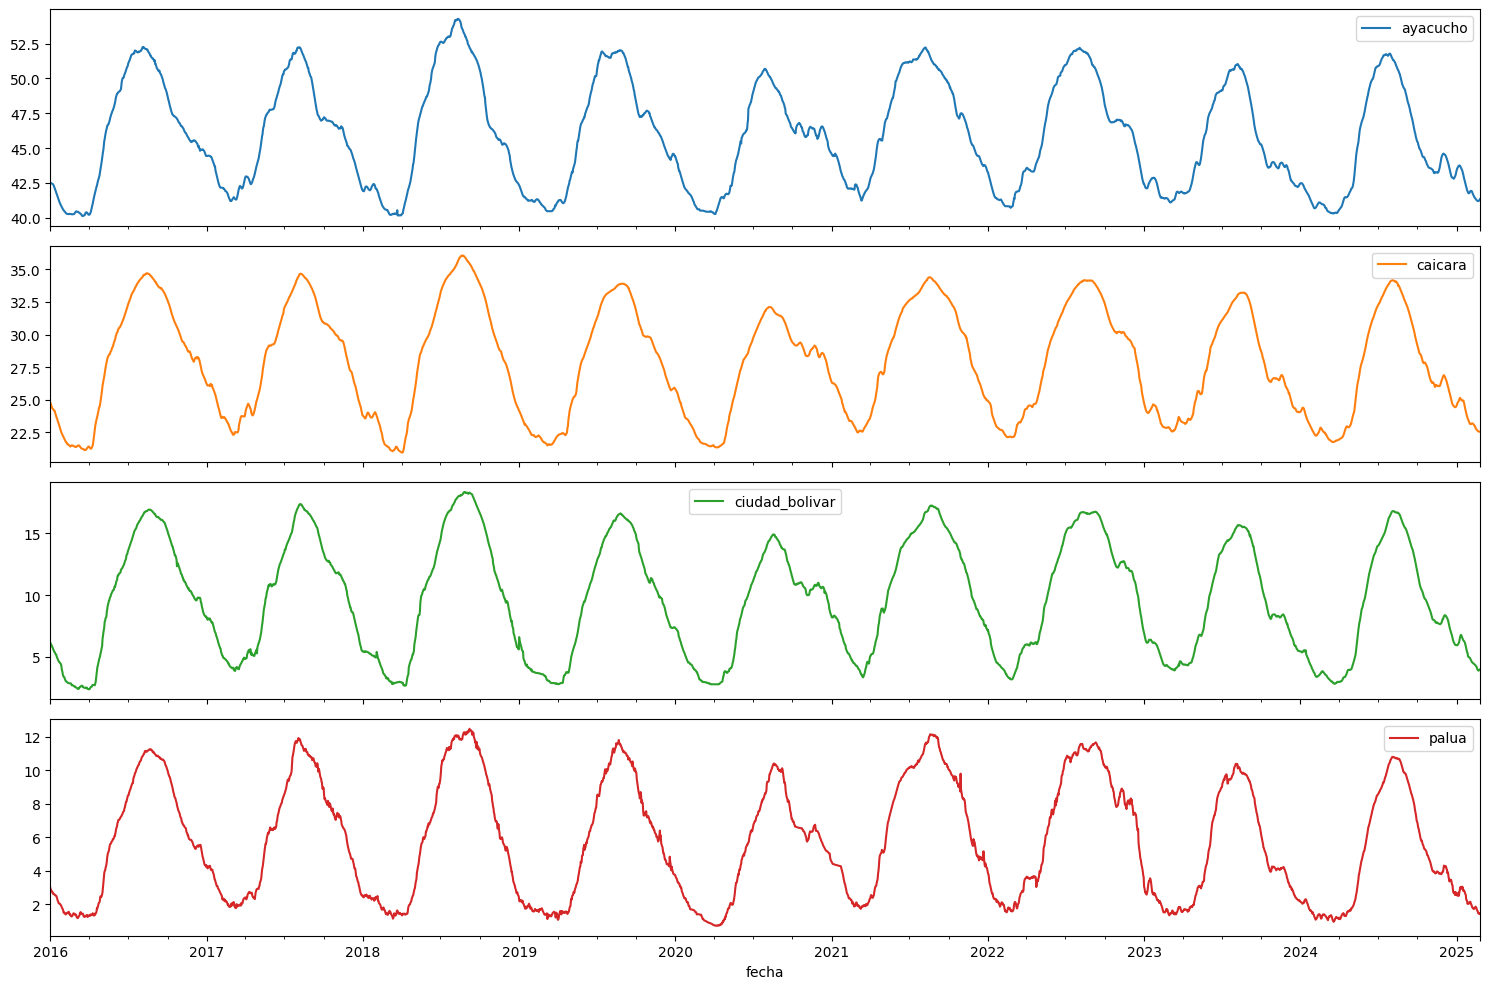

In [54]:
# Graficar valores de cada columna
data[data["fecha"] >= "2016/01/01"].set_index("fecha")[["ayacucho", "caicara", "ciudad_bolivar", "palua"]].plot(
    subplots=True, figsize=(15, 10)
)
plt.tight_layout()


In [55]:
# Resumen del modelo
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 100)            │        42,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 56)             │         5,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 14, 4)          │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 142,970 (558.48 KB)

 Trainable params: 47,656 (186.16 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 95,314 (372.32 KB)

In [56]:
# Error cuadrático medio entre las predicciones de 2024 y los valores reales
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
)

mse_2024 = mean_squared_error(
    data[data["fecha"].dt.year == 2024].drop("fecha", axis=1).values,
    predictions_df.values,
)
print("Error cuadrático medio (MSE) para 2024:", mse_2024)

# Raíz del error cuadrático medio (RMSE)
rmse_2024 = np.sqrt(mse_2024)
print("Raíz del error cuadrático medio (RMSE) para 2024:", rmse_2024)

# Error absoluto medio (MAE) entre las predicciones de 2024 y los valores reales
mae_2024 = mean_absolute_error(
    data[data["fecha"].dt.year == 2024].drop("fecha", axis=1).values,
    predictions_df.values,
)
print("Error absoluto medio (MAE) para 2024:", mae_2024)

mape_2024 = mean_absolute_percentage_error(
    data[data["fecha"].dt.year == 2024].drop("fecha", axis=1).values,
    predictions_df.values,
)
print(f"Error absoluto medio porcentual (MAPE) para 2024: {mape_2024 * 100:.2f}%")

precision = 1 - mape_2024
print(f"Precisión del modelo para 2024: {(precision * 100):.2f}%")


Error cuadrático medio (MSE) para 2024: 2.855964151690454
Raíz del error cuadrático medio (RMSE) para 2024: 1.6899598077145073
Error absoluto medio (MAE) para 2024: 1.2106024656643999
Error absoluto medio porcentual (MAPE) para 2024: 10.62%
Precisión del modelo para 2024: 89.38%
